In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


## Extract the samples from all files

In [79]:
samples = {}
methods = ["binary", "ohe", "unary", "domain_wall"]

for method in methods:

    # iterate over different size
    for filename in os.listdir(f"{method}/"):

        # load the data
        data = np.load(f"{method}/{filename}", allow_pickle=True)
        
        # iterate over each trial which has different penalty weights
        for trial in data:

            # extract the penalty weights
            weights = tuple(trial["penalty_weights"].values())
            
            # extract the solutions
            solutions = trial["solutions"]

            sample_array = []

            for sample in solutions:
                
                # store the energy
                sample_array.append(sample["sample"])

            

            if method in list(samples.keys()):
                if filename in list(samples[method].keys()):
                    # if the filename already exists, append the energy array
                    samples[method][filename].setdefault(weights, sample_array)
                else:
                    # if the filename does not exist, create a new entry
                    samples[method].setdefault(filename, {weights: sample_array})
            else:
                samples.setdefault(method, {filename: {weights: sample_array}})

## Convert the samples to a magic square count

#### Domain Wall

In [53]:
def domain_wall_to_decimal(item):
    if [1] * item.count(1) + [0] * item.count(0) == item:
        return sum(item)
    return -1

def domain_wall_get_grid(sample):
    grid = np.zeros((len(sample), len(sample)))
    
    for i in range(len(sample)):
        for j in range(len(sample)):

            # get the item
            item = list(sample[i][j])
            
            grid[i][j] = domain_wall_to_decimal(item)
            
    return np.array(grid)

def check_domain_wall(sample):

    count = 0
    for i in range(len(sample)):
        for j in range(len(sample)):
            item = list(map(int, sample[i][j]))
            
            if [1] * item.count(1) + [0] * item.count(0) != item:
                count += 1

    if count == 0:
        return True
    
    return count

def check_domain_wall_unique(sample):
    grid = get_grid(sample)

    if len(set(grid.flatten())) == len(sample) * len(sample):
        return True
    return False

def check_domain_wall_sum_col(sample):

    # get grid and sum cols
    grid = get_grid(sample)
    sums = [int(sum(grid[:,i])) for i in range(len(sample))]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def check_domain_wall_sum_row(sample):
    
    # get grid and sum rows
    grid = get_grid(sample)
    sums = [int(sum(grid[i,:])) for i in range(len(sample))]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def is_domain_wall_magic(sample):
    return check_domain_wall(sample) and check_domain_wall_unique(sample) and check_domain_wall_sum_col(sample) and check_domain_wall_sum_row(sample)

#### One Hot Encoding

In [54]:
def ohe_to_decimal(item):
    if sum(item) == 1:
        return item.index(1) + 1
    else:
        return -1

def ohe_get_grid(sample):
    grid = np.zeros((len(sample), len(sample)))
    
    for i in range(len(sample)):
        for j in range(len(sample)):

            # get the item
            item = list(sample[i][j])
            
            grid[i][j] = ohe_to_decimal(item)
            
    return np.array(grid)

def check_ohe(sample):
    
    count = 0

    # count how many samples are not one hot encoded
    for i in range(len(sample)):
        for j in range(len(sample)):
            if sum(sample[i][j]) != 1:
                count += 1

    # return the number of samples that are not one hot encoded
    if count > 0:
        return count

    # return True if all samples are one hot encoded
    return True

def check_ohe_unique(sample):
    grid = ohe_get_grid(sample)

    if len(set(grid.flatten())) == len(sample) * len(sample):
        return True
    return False

def check_ohe_sum_col(sample):

    # get grid and sum cols
    grid = ohe_get_grid(sample)
    sums = [int(sum(grid[:,i])) for i in range(len(sample))]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def check_ohe_sum_row(sample):
    
    # get grid and sum rows
    grid = ohe_get_grid(sample)
    sums = [int(sum(grid[i,:])) for i in range(len(sample))]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def is_ohe_magic(sample):
    return check_ohe(sample) and check_ohe_unique(sample) and check_ohe_sum_col(sample) and check_ohe_sum_row(sample)

#### Binary

In [56]:

correct_samples = {}

for method in list(samples.keys()):
    for filename in list(samples[method].keys()):
        for weight_configuration in list(samples[method][filename].keys()):
            
            data = samples[method][filename]
            sample_array = data[weight_configuration]

            unique_count = 0
            format_count = 0
            col_count = 0
            row_count = 0
            magic_count = 0
            
            

            # iterate over each sample
            for sample in sample_array:
                
                if method == "domain_wall":
                    if check_domain_wall_unique(sample):
                        unique_count += 1
                    if check_domain_wall_sum_col(sample):
                        col_count += 1
                    if check_domain_wall_sum_row(sample):
                        row_count += 1
                    if check_domain_wall(sample):
                        format_count += 1
                    if is_domain_wall_magic(sample):
                        magic_count += 1

                if method == "ohe":
                    if check_ohe_unique(sample):
                        unique_count += 1
                    if check_ohe_sum_col(sample):
                        col_count += 1
                    if check_ohe_sum_row(sample):
                        row_count += 1
                    if check_ohe(sample):
                        format_count += 1
                    if is_ohe_magic(sample):
                        magic_count += 1

            if method in correct_samples:
                if filename in correct_samples[method]:
                    correct_samples[method][filename].setdefault(weight_configuration, {"unique": unique_count, "col_sum": col_count, "row_sum": row_count, "format": format_count, "magic": magic_count})
                else:
                    correct_samples[method].setdefault(filename, {weight_configuration: {"unique": unique_count, "col_sum": col_count, "row_sum": row_count, "format": format_count, "magic": magic_count}})
                    
            else:
                correct_samples.setdefault(method, {filename: {weight_configuration: {"unique": unique_count, "col_sum": col_count, "row_sum": row_count, "format": format_count, "magic": magic_count}}})

In [61]:
list(correct_samples["ohe"].keys())

['solutions_3.npy']

## Find the Top 10 Weight configurations based on the number of magic squares produced

In [42]:
a = sorted(correct_samples["domain_wall"]["solutions_5.npy"], key=lambda x: correct_samples["domain_wall"]["solutions_5.npy"][x]["unique"] + correct_samples["domain_wall"]["solutions_5.npy"][x]["row_sum"] + correct_samples["domain_wall"]["solutions_5.npy"][x]["col_sum"], reverse=True)
for i in a:
    print(i, correct_samples["domain_wall"]["solutions_5.npy"][i]) 


(1, 1, 1, 4) {'unique': 0, 'col_sum': 10, 'row_sum': 10, 'format': 10, 'magic': 0}
(1, 1, 2, 3) {'unique': 0, 'col_sum': 10, 'row_sum': 10, 'format': 10, 'magic': 0}
(1, 1, 3, 3) {'unique': 0, 'col_sum': 10, 'row_sum': 10, 'format': 10, 'magic': 0}
(1, 1, 3, 4) {'unique': 0, 'col_sum': 10, 'row_sum': 10, 'format': 10, 'magic': 0}
(1, 1, 4, 1) {'unique': 0, 'col_sum': 10, 'row_sum': 10, 'format': 10, 'magic': 0}
(1, 1, 4, 2) {'unique': 0, 'col_sum': 10, 'row_sum': 10, 'format': 10, 'magic': 0}
(1, 1, 4, 3) {'unique': 0, 'col_sum': 10, 'row_sum': 10, 'format': 10, 'magic': 0}
(1, 1, 4, 4) {'unique': 0, 'col_sum': 10, 'row_sum': 10, 'format': 10, 'magic': 0}
(1, 1, 1, 3) {'unique': 0, 'col_sum': 9, 'row_sum': 9, 'format': 10, 'magic': 0}
(1, 1, 2, 1) {'unique': 0, 'col_sum': 9, 'row_sum': 9, 'format': 10, 'magic': 0}
(1, 1, 2, 2) {'unique': 0, 'col_sum': 9, 'row_sum': 9, 'format': 10, 'magic': 0}
(1, 1, 2, 4) {'unique': 0, 'col_sum': 9, 'row_sum': 9, 'format': 10, 'magic': 0}
(1, 1, 3, 1)

In [62]:
# select 10 best penalty pairings
correct_samples_sorted = {}

for method in list(correct_samples.keys()):
    for filename in list(correct_samples[method].keys()):

        data = correct_samples[method][filename]
        
        # sort the energy values by the minimum energy produced
        correct_samples_new = sorted(correct_samples[method][filename], key=lambda x: data[x]["magic"], reverse=True)[:10]
        

        # add the found penalty pairings to the sorted dictionary
        for i in correct_samples_new:
            if method in list(correct_samples_sorted.keys()):
                if filename in list(correct_samples_sorted[method].keys()):
                    # if the filename already exists, append the energy array
                    correct_samples_sorted[method][filename].setdefault(i, correct_samples[method][filename][i])
                else:
                    # if the filename does not exist, create a new entry
                    correct_samples_sorted[method].setdefault(filename, {i: correct_samples[method][filename][i]})
            else:
                # if the filename does not exist, create a new entry
                correct_samples_sorted.setdefault(method, {filename: {i: correct_samples[method][filename][i]}})

## Scatter Plot

In [63]:
method = "ohe"
filename = "solutions_3.npy"

data = np.load(f"{method}/{filename}", allow_pickle=True)
number_of_trials = data[0]["samples"]

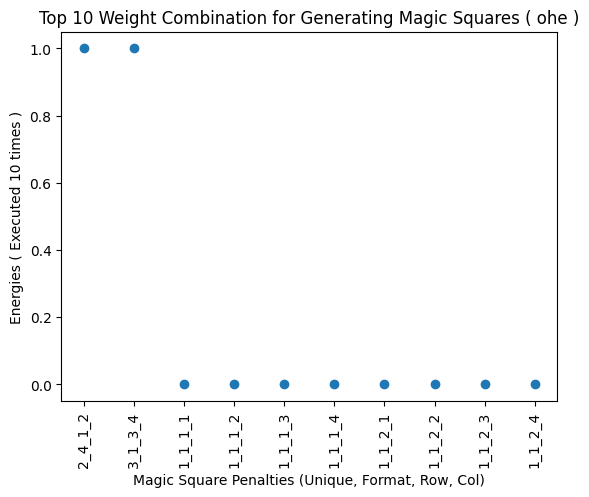

In [64]:
x = [f"{x[0]}_{x[1]}_{x[2]}_{x[3]}" for x in correct_samples_sorted[method][filename].keys()]
y = list([i["magic"] for i in correct_samples_sorted[method][filename].values()])

plt.title(f"Top 10 Weight Combination for Generating Magic Squares ( {method} )")
plt.xlabel("Magic Square Penalties (Unique, Format, Row, Col)")
plt.ylabel(f"Energies ( Executed {number_of_trials} times )")


plt.scatter(x, y)
plt.xticks(rotation=90)
plt.show()

## Take a look at the magic squares generated between different orders

In [101]:
orders = ["solutions_3.npy", "solutions_4.npy", "solutions_5.npy"]
condensed_magic_squares = {}

for order in orders:
    for method in samples.keys():
        if order in samples[method]:
            # print(f"{samples[method][order]}")
            for weights, solutions in samples[method][order].items():
                for square in solutions:
                    if method == "domain_wall":
                        if is_domain_wall_magic(square):

                            # get the grid
                            grid = tuple([tuple(i) for i in domain_wall_get_grid(square)])

                            # add count to dictionary
                            if method not in condensed_magic_squares:
                                condensed_magic_squares.setdefault(method, {grid: 1})
                            else:
                                if grid not in condensed_magic_squares[method]:
                                    condensed_magic_squares[method].setdefault(grid, 1)
                                else:
                                    condensed_magic_squares[method][grid] += 1

                    if method == "ohe":
                        if is_ohe_magic(square):

                            # get the grid
                            grid = tuple([tuple(i) for i in ohe_get_grid(square)])

                            # add count to dictionary
                            if method not in condensed_magic_squares:
                                condensed_magic_squares.setdefault(method, {grid: 1})
                            else:
                                if grid not in condensed_magic_squares[method]:
                                    condensed_magic_squares[method].setdefault(grid, 1)
                                else:
                                    condensed_magic_squares[method][grid] += 1

In [115]:
for method in condensed_magic_squares.keys():
    print(f"{method} : {len(condensed_magic_squares[method])} unique magic squares")
    for grid, count in condensed_magic_squares[method].items():
        for row in grid:
            for element in row:
                print(int(element), end=" ")

            print()
        print(f" {count}\n")

ohe : 2 unique magic squares
3 5 7 
4 9 2 
8 1 6 
 1

9 1 5 
4 8 3 
2 6 7 
 1

domain_wall : 59 unique magic squares
3 7 2 
1 5 6 
8 0 4 
 4

2 4 6 
7 0 5 
3 8 1 
 4

0 8 4 
5 1 6 
7 3 2 
 3

1 3 8 
5 7 0 
6 2 4 
 2

6 4 2 
1 8 3 
5 0 7 
 2

4 8 0 
2 3 7 
6 1 5 
 2

7 2 3 
5 6 1 
0 4 8 
 2

0 5 7 
4 6 2 
8 1 3 
 1

5 1 6 
7 3 2 
0 8 4 
 5

7 5 0 
3 1 8 
2 6 4 
 1

3 1 8 
2 6 4 
7 5 0 
 2

3 2 7 
1 6 5 
8 4 0 
 5

1 6 5 
8 4 0 
3 2 7 
 1

7 5 0 
2 6 4 
3 1 8 
 4

2 4 6 
3 8 1 
7 0 5 
 3

0 4 8 
5 6 1 
7 2 3 
 1

5 7 0 
6 2 4 
1 3 8 
 2

8 3 1 
0 7 5 
4 2 6 
 3

2 6 4 
3 1 8 
7 5 0 
 2

1 8 3 
5 0 7 
6 4 2 
 1

7 3 2 
5 1 6 
0 8 4 
 4

3 7 2 
8 0 4 
1 5 6 
 1

4 6 2 
0 5 7 
8 1 3 
 2

8 4 0 
1 6 5 
3 2 7 
 1

7 3 2 
0 8 4 
5 1 6 
 4

1 6 5 
3 2 7 
8 4 0 
 2

7 0 5 
2 4 6 
3 8 1 
 1

6 5 1 
4 0 8 
2 7 3 
 3

6 2 4 
5 7 0 
1 3 8 
 3

2 6 4 
7 5 0 
3 1 8 
 2

3 8 1 
7 0 5 
2 4 6 
 1

4 6 2 
8 1 3 
0 5 7 
 4

4 2 6 
8 3 1 
0 7 5 
 3

8 4 0 
3 2 7 
1 6 5 
 1

8 3 1 
4 2 6 
0 7 5 
 3

0 7 5 
4